# Patent Application Trend Analysis
## Group4:
## Kumar Ashwarya, Seok Hyun Chang, Ryosuke Kurematsu, Ravikumar Patel, Ethan Winter


# This is our team's colab file to review patents from 2011-2021 in an effort to answer the following questions:
- Can we identify trends of technological advancements?
- Can technological development domains be detected using patent descriptions? 

Our analysis flow is as follows:
1. Data collection and data preprocessing
2. Trend analysis
3. Topic modeling
4. Co-occurrence analysis

We've elected to run our process on Google's Colaboratory due to the extreme size of our source data. For the purpose of this project (and the machines of our Professor and TAs), we have limited the datasets to be just a few thousand from each year for trend analysis. 

##1. Data collection and data preprocessing

We use repository for the United Stetes Intellectual Property data supported by the Office of Chief Economist and the United States Patent and Trademark Office(USPTO). We pick Brief Summary Text table, which contains the feature of patent number, patent summary text (Unstructured).


Data Source:<br>
https://patentsview.org/download/data-download-tables

Data Dictionary:<br>
https://patentsview.org/download/data-download-dictionary



In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

os.chdir('/content/gdrive/My Drive/UDAP_project/colab') #change the path here


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import re
import spacy
import re
from collections import Counter
import gc
import time
starttime = time.time()

## We begin by limiting our datasets to just 5000 rows per year. 
After these datasets were limited, we saved each years a new "smallset" tsv. This section is commented out as it is unnecessary to run again.

In [ ]:
# num_patents_per_yr = 5000 #1000 for quick run

# for year in range(2011, 2022):
#     small_df = pd.read_csv('brf_sum_text_' + str(year) + '.tsv', sep='\t', nrows= num_patents_per_yr)
#     small_df.to_csv('brf_sum_text_' + str(year) + '_smallset.tsv', sep='\t', index=False)

# print(f"{time.time() - starttime}")

### Now that our datasets were limited to 5000 rows, we limit again based on the presence of the words "Summary" and "Description" within the "text" field. 
From our preliminary research, we found that the vast majority of patent submissions (~85%) included "summary" or "description" at the beginning of the invention's description section. The text field appears to be loosely formatted around these two words, but not strictly enforced. 

In [ ]:
sub ='SUMMARY'
sub2 ='DESCRIPTION'

df_both_pool = pd.DataFrame(columns = ['uuid', 'patent_id', 'text', 'Year'])

for year in range(2011, 2022):

    holder_db = pd.read_csv('brf_sum_text_' + str(year) + '_smallset.tsv', sep='\t') #nrows= 100 for short run

    non_sub = np.array(~holder_db["text"].str.contains(sub))
    #df_non_sub = holder_db[non_sub]
    non_sub2 = np.array(~holder_db["text"].str.contains(sub2))
    #df_non_sub2 = holder_db[non_sub2]

    
    #print('Total Year Patents', len(holder_db))
    #print('Total w/o '+sub, len(df_non_sub), 'of', len(holder_db))
    #print('Total w/o '+sub2, len(df_non_sub2), 'of', len(holder_db))
    
    non_both = np.full(len(holder_db), False)

    for x in range(0, len(holder_db)):
        if non_sub[x] == False or non_sub2[x] == False:
            non_both[x] = True # True when Summary or Description ARE PRESENT in the patent.

    df_both = holder_db[non_both]
    df_both['Year'] = year

    df_both_pool = df_both_pool.append(df_both, ignore_index=True)

    #print('Prob of '+sub+':', str(round(1-np.mean(non_sub),4)*100)+'%')
    #print('Prob of '+sub2+':', str(round(1-np.mean(non_sub2),4)*100)+'%')
    
    print('Prob of either for ' + str(year) + ' :', str(round(np.mean(non_both),4)*100)+'%')

    del df_both
    gc.collect()

    del holder_db
    gc.collect()


print(f"{time.time() - starttime}")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Prob of either for 2011 : 86.11999999999999%
Prob of either for 2012 : 83.66%
Prob of either for 2013 : 82.84%
Prob of either for 2014 : 81.62%
Prob of either for 2015 : 85.32%
Prob of either for 2016 : 84.28%
Prob of either for 2017 : 85.38%
Prob of either for 2018 : 84.24000000000001%
Prob of either for 2019 : 85.84%
Prob of either for 2020 : 86.16%
Prob of either for 2021 : 88.9%
21.670368432998657


In [ ]:
"""
#del df_non_sub
#del df_non_sub2
del non_sub
del non_sub2
gc.collect()
"""

'\n#del df_non_sub\n#del df_non_sub2\ndel non_sub\ndel non_sub2\ngc.collect()\n'

#### Again, we have commented these sections out as they are unnecessary to run again. 
Overall we are combining and saving the new limited (by Summary and Description) dataset.

In [ ]:
#df_both_pool.to_csv("full_data_pre_extraction" + str(num_patents_per_yr) + ".tsv", sep='\t', index=False)

In [ ]:
#df_both_pool = pd.read_csv("full_data_pre_extraction" + str(num_patents_per_yr) + ".tsv", sep='\t') #skiprows = 1500000, nrows= 500000
#df_both_pool.columns = ['uuid', 'patent_id', 'text', 'Year']

In [ ]:
data_len = df_both_pool.shape[0]
data_len

43162

### Next we limit our text fields to all text that follows the words "Summary" or "Description". 
We specifically call all text that follows the next instance of a line break. This is done because not all patents write "Summary" on a single line; some read as "Summary of the Invention."


In [ ]:
#df_both_pool_short = df_both_pool.copy()

regex_list = ['SUMMARY', 'DESCRIPTION']

#data_len = df_both_pool_short.shape[0]

for x in range(data_len):

    content_str = df_both_pool["text"].iloc[x]

    lowest_idx = len(content_str)

    for y in regex_list:
        if re.search(y, content_str):
            idx_holder = re.search(y, content_str)
            strt_pt = idx_holder.span()[0]
            end_pt = idx_holder.span()[1]
            if re.search('\n', content_str[strt_pt:]):
                n_holder = re.search('\n', content_str[strt_pt:])
                n_hold_end_pt = n_holder.span()[1]
                extraction_strt_pt = n_hold_end_pt + end_pt
                # print(strt_pt, end_pt, extraction_strt_pt, len(np_both[x,2]))
                if lowest_idx > extraction_strt_pt:
                    lowest_idx = extraction_strt_pt
                    # print(content_str[lowest_idx-6:])
                    # print(y, lowest_idx)
                    # print(np_both[x, 2][lowest_idx-50:lowest_idx+5])
    df_both_pool.loc[x, "text"] = content_str[lowest_idx-6:]

    if x % 10000 == 0:
        print(f"process completed upto row {x}")

print(f"{time.time() - starttime}")

process completed upto row 0
process completed upto row 10000
process completed upto row 20000
process completed upto row 30000
process completed upto row 40000
212.92554783821106


#### Commented out for redundancy. 

In [ ]:
#df_both_pool.to_csv("full_data_extracted" + str(num_patents_per_yr) + ".tsv", sep='\t', index=False)

In [ ]:
#df_both_pool = pd.read_csv('full_data_extracted" + str(num_patents_per_yr) + ".tsv', sep='\t')
#df_both_pool.columns = ['uuid', 'patent_id', 'text', 'Year']

##2. Trend Analysis (From 2011-2021 Data)

## In this next section, we set up a histogram for each year of data. 
This step is taken to do a preliminary review of the most common words used within our patents. 

In [ ]:
data_len = df_both_pool.shape[0]
data_len

43162

In [ ]:

nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

num_words_per_yr = 500

word_histogram_2011 = Counter()
word_histogram_2012 = Counter()
word_histogram_2013 = Counter()
word_histogram_2014 = Counter()
word_histogram_2015 = Counter()
word_histogram_2016 = Counter()
word_histogram_2017 = Counter()
word_histogram_2018 = Counter()
word_histogram_2019 = Counter()
word_histogram_2020 = Counter()
word_histogram_2021 = Counter()

word_histogram_collect = [word_histogram_2011,
                          word_histogram_2012,
                          word_histogram_2013,
                          word_histogram_2014,
                          word_histogram_2015,
                          word_histogram_2016,
                          word_histogram_2017,
                          word_histogram_2018,
                          word_histogram_2019,
                          word_histogram_2020,
                          word_histogram_2021]


    # #. For each batch, parse it individually
    # for x in range(0, len(batchs)):

for patent_num in range(data_len):

    #print(df_both_pool["Year"].iloc[patent_num])

    for i in range(2011, 2022):
        if df_both_pool["Year"].iloc[patent_num] == i:

            text = df_both_pool["text"].iloc[patent_num]
            if len(text) >= (1000000 - 10):
                text = text[:1000000 - 10] # this is to prevent error: ValueError: [E088] Text of length 1314112 exceeds maximum of 1000000.
            parsed_text = nlp(text)
            #. For each token inside the batch
            for token in parsed_text:
                #. Grab the string from the token
                original_token_text = token.lemma_.lower()
                if not nlp.vocab[original_token_text].is_stop:
                    if re.match('[a-zA-Z]+$', original_token_text):
                        word_histogram_collect[i-2011][original_token_text] += 1


    if patent_num % 1000 == 0:
        print(f"process completed upto row {patent_num}")
        print(f"{time.time() - starttime}")

    if patent_num != 0 and patent_num % 50000 == 0:

        word_count_df = pd.DataFrame(columns = ['Year', 'word', 'count'])

        n = 0

        for word_histogram in word_histogram_collect:

            sorted_token_count_pairs = word_histogram.most_common()[:num_words_per_yr]

            for token, count in sorted_token_count_pairs:

                word_row = {'Year': 2011+n, 'word': token, 'count': count}

                word_count_df = word_count_df.append(word_row, ignore_index = True)

            n += 1

        word_count_df.to_csv("word_count_df_0_500k_" + str(patent_num) + ".tsv", sep='\t', index=False)



word_count_df = pd.DataFrame(columns = ['Year', 'word', 'count'])

n = 0

for word_histogram in word_histogram_collect:

    sorted_token_count_pairs = word_histogram.most_common()[:num_words_per_yr]

    for token, count in sorted_token_count_pairs:

        #print("Year: ", 2011+n, "   ", token, ":", count)

        word_row = {'Year': 2011+n, 'word': token, 'count': count}

        word_count_df = word_count_df.append(word_row, ignore_index = True)

    n += 1

print(word_count_df)

print(f"{time.time() - starttime}")

process completed upto row 0
213.79980993270874
process completed upto row 1000
245.86894464492798
process completed upto row 2000
293.32768988609314
process completed upto row 3000
323.6986577510834
process completed upto row 4000
353.34423184394836
process completed upto row 5000
381.583220243454
process completed upto row 6000
427.72183060646057
process completed upto row 7000
458.61215329170227
process completed upto row 8000
488.6454563140869
process completed upto row 9000
518.6964726448059
process completed upto row 10000
554.6641285419464
process completed upto row 11000
596.2030544281006
process completed upto row 12000
626.7717478275299
process completed upto row 13000
656.5689780712128
process completed upto row 14000
693.2934973239899
process completed upto row 15000
742.3899128437042
process completed upto row 16000
773.5330829620361
process completed upto row 17000
804.1429121494293
process completed upto row 18000
837.2203178405762
process completed upto row 19000
887.77

#### Additional redundant code left for posterity

In [ ]:
# word_count_df.to_csv("word_count_full_data" + str(num_patents_per_yr) + ".tsv", sep='\t', index=False)
# print(f"{time.time() - starttime}")

In [ ]:
print(word_count_df)

      Year       word  count
0     2011  invention  24099
1     2011     second  21072
2     2011    include  18431
3     2011    provide  17854
4     2011    present  15561
...    ...        ...    ...
5495  2021   receptor    249
5496  2021   effector    248
5497  2021   molecule    248
5498  2021   anterior    248
5499  2021     switch    247

[5500 rows x 3 columns]


##3. Topic Modeling (Only 2021 Data)

## Next we begin work on Topic Modeling to better explain how patents from the year 2021 are similar to each other. 
Although we could use each year in our model, it is extremely resource intensive so we elected to demonstrate on 2021. However, in order to deeply dive into the 2021 text data, we used all the data rather than sampling, then cut verbose part of each text. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re

%matplotlib inline

Load the 2021 summary data and cut the verbose part of text data.

In [ ]:
%%time
data = pd.read_csv('brf_sum_text_2021.tsv',sep='\t')

CPU times: user 39.8 s, sys: 16.9 s, total: 56.7 s
Wall time: 1min 9s


In [ ]:
regex_list = ['SUMMARY', 'DESCRIPTION']

for x in range(len(data)):
    content_str = data["text"].iloc[x]
    lowest_idx = len(content_str)

    for y in regex_list:
        if re.search(y, content_str):
            idx_holder = re.search(y, content_str)
            strt_pt = idx_holder.span()[0]
            end_pt = idx_holder.span()[1]
            if re.search('\n', content_str[strt_pt:]):
                n_holder = re.search('\n', content_str[strt_pt:])
                n_hold_end_pt = n_holder.span()[1]
                extraction_strt_pt = n_hold_end_pt + end_pt
                if lowest_idx > extraction_strt_pt:
                    lowest_idx = extraction_strt_pt
                    
    data.loc[x, "text"] = content_str[lowest_idx-6:]        

In [ ]:
docs = [data.iloc[i, 2] for i in range(len(data))]
#del data

We use TfidfVectorizer to vectorize words in each patents.

In [ ]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', min_df=100, max_df=0.8) 
X = vectorizer.fit_transform(docs)#.toarray()
del docs
print(len(vectorizer.vocabulary_))

18977
CPU times: user 3min 8s, sys: 1.52 s, total: 3min 10s
Wall time: 3min 9s


### In an effort to find the correct number of topics we used Coherence and Uniquewords plots.
We are able to identify that although there is higher coherence at five topics, it comes at the cost of fewer unique words. Because of this, we elect to go with six topics which has a slightly reduced coherence but more unique words. 

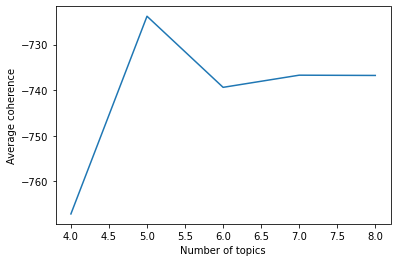

In [ ]:
from IPython.display import Image
Image("Coherence.png")

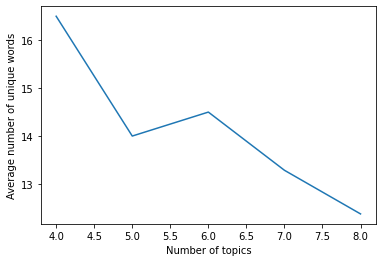

In [ ]:
Image("Uniquewords.png")

The code to pick the optimal topic number as shown below took more than 3 hours to run, so we just ran it once to get the optimised topic number, which is 6. We have commented it out becuase of the same reason. The above two png files are a result of the below calculation. 

In [ ]:
# # Topic Coherence Calculation functions
#num_top_words = 20
# def prob_see_word1_given_see_word2(word1, word2, vectorizer, eps=0.1):
#     word1_column_idx = vectorizer.vocabulary_[word1]
#     word2_column_idx = vectorizer.vocabulary_[word2]
#     documents_with_word1 = (X[:, word1_column_idx].toarray().flatten() > 0)
#     documents_with_word2 = (X[:, word2_column_idx].toarray().flatten() > 0)
#     documents_with_both_word1_and_word2 = documents_with_word1 * documents_with_word2
#     return np.log2((documents_with_both_word1_and_word2.sum() + eps) / documents_with_word2.sum())


# def compute_average_coherence(topic_word_distributions, num_top_words, vectorizer, verbose=True):
#     vocab = vectorizer.get_feature_names()
#     num_topics = len(topic_word_distributions)
#     average_coherence = 0
#     for topic_idx in range(num_topics):
#         if verbose:
#             print('[Topic ', topic_idx, ']', sep='')
        
#         sort_indices = np.argsort(topic_word_distributions[topic_idx])[::-1]
#         coherence = 0.
#         for top_word_idx1 in sort_indices[:num_top_words]:
#             word1 = vocab[top_word_idx1]
#             for top_word_idx2 in sort_indices[:num_top_words]:
#                 word2 = vocab[top_word_idx2]
#                 if top_word_idx1 != top_word_idx2:
#                     coherence += prob_see_word1_given_see_word2(word1, word2, vectorizer, 0.1)
        
#         if verbose:
#             print('Coherence:', coherence)
#             print()
#         average_coherence += coherence
#     average_coherence /= num_topics
#     if verbose:
#         print('Average coherence:', average_coherence)
#     return average_coherence


# # Number of Unique Words Calculation function
# def compute_average_num_unique_words(topic_word_distributions, num_top_words, vectorizer, verbose=True):
#     vocab = vectorizer.get_feature_names()
#     num_topics = len(topic_word_distributions)
#     average_number_of_unique_top_words = 0
#     for topic_idx1 in range(num_topics):
#         if verbose:
#             print('[Topic ', topic_idx1, ']', sep='')
        
#         sort_indices1 = np.argsort(topic_word_distributions[topic_idx1])[::-1]
#         num_unique_top_words = 0
#         for top_word_idx1 in sort_indices1[:num_top_words]:
#             word1 = vocab[top_word_idx1]
#             break_ = False
#             for topic_idx2 in range(num_topics):
#                 if topic_idx1 != topic_idx2:
#                     sort_indices2 = np.argsort(topic_word_distributions[topic_idx2])[::-1]
#                     for top_word_idx2 in sort_indices2[:num_top_words]:
#                         word2 = vocab[top_word_idx2]
#                         if word1 == word2:
#                             break_ = True
#                             break
#                     if break_:
#                         break
#             else:
#                 num_unique_top_words += 1
#         if verbose:
#             print('Number of unique top words:', num_unique_top_words)
#             print()

#         average_number_of_unique_top_words += num_unique_top_words
#     average_number_of_unique_top_words /= num_topics
    
#     if verbose:
#         print('Average number of unique top words:', average_number_of_unique_top_words)
    
#     return average_number_of_unique_top_words

In [ ]:
# %%time
# # Optimize topick number k


# k_values = range(4, 9)
# avg_coherences = []
# avg_num_unique_words = []

# for k in k_values:
#     lda_candidate = LatentDirichletAllocation(n_components=k, random_state=0)
#     lda_candidate.fit(X)
#     topic_word_distributions = np.array([row / row.sum() for row in lda_candidate.components_])
#     print('-' * 80)
#     print('Number of topics:', k)
#     print()
#     print_top_words(topic_word_distributions, num_top_words, vectorizer)
#     print()
#     print()
    
#     avg_coherences.append(compute_average_coherence(topic_word_distributions, num_top_words, vectorizer, False))
#     avg_num_unique_words.append(compute_average_num_unique_words(topic_word_distributions, num_top_words, vectorizer, False))

In [ ]:
# # Plot Average Coherence
# plt.plot(k_values, avg_coherences)
# plt.xlabel('Number of topics')
# plt.ylabel('Average coherence')
# plt.show()

In [ ]:
# # Plot Average Number of Unique Words
# plt.plot(k_values, avg_num_unique_words)
# plt.xlabel('Number of topics')
# plt.ylabel('Average number of unique words')
# plt.show()

### Here we beging the actual code for Topic Modeling.
As above, we elect to use six topics and utilize an LDA model to handle the topic modeling.

In [ ]:
%%time
# We pick num_topics = 6 using the optimization of 
num_topics = 6

from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=num_topics, random_state=0)
lda.fit(X)

CPU times: user 16min 45s, sys: 7min 56s, total: 24min 42s
Wall time: 15min 39s


### The following acts as a function to check the top five words of each LDA topic. 

In [ ]:
topic_word_distributions = np.array([row / row.sum() for row in lda.components_])

In [ ]:
#exporting the top 5 frequent words for each topic. 

num_top_words = 5

top_word_lis = []

def print_top_words(topic_word_distributions, num_top_words, vectorizer):
    vocab = vectorizer.get_feature_names()
    num_topics = len(topic_word_distributions)
    print('Displaying the top %d words per topic and their probabilities within the topic...' % num_top_words)
    print()

    for topic_idx in range(num_topics):
        print('[Topic ', topic_idx, ']', sep='')
        sort_indices = np.argsort(-topic_word_distributions[topic_idx])
        for rank in range(num_top_words):
            word_idx = sort_indices[rank]
            
            top_word_lis.append(vocab[word_idx])
            
            print(vocab[word_idx], ':',
                  topic_word_distributions[topic_idx, word_idx])
        print()

print_top_words(topic_word_distributions, num_top_words, vectorizer)

Displaying the top 5 words per topic and their probabilities within the topic...

[Topic 0]
ces : 0.009992685138475963
ing : 0.008829888959415184
acid : 0.007388019803174564
nce : 0.006431802249081079
seq : 0.006258648560859607

[Topic 1]
image : 0.009727863863135686
signal : 0.009143825730947172
light : 0.00728505104434143
second : 0.0071541102452088515
power : 0.005836509658223497

[Topic 2]
member : 0.007724594584583107
portion : 0.007544462183811528
second : 0.007377443498521834
end : 0.006816776960118446
body : 0.005572642415766491

[Topic 3]
data : 0.011646475507133857
ion : 0.010774213238245489
user : 0.00796856112539927
device : 0.007741285451201469
information : 0.007463733570212866

[Topic 4]
layer : 0.015545013049097058
substrate : 0.006476177265019511
material : 0.005913188757995272
electrode : 0.004967984476086219
semiconductor : 0.004805017731969404

[Topic 5]
second : 0.006944618489172732
portion : 0.006326518123243262
surface : 0.006223433259036357
fluid : 0.00520406375

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# # For check the text itself in each topick
# %%time
# topic_proportions = lda.transform(X)


# # Patent text in each Topic
# pat_title = list(data["text"])

# for i in range(3):
#     idx = np.argsort(topic_proportions[:,i])[::-1]
    
#     print("Topic #" + str(i) + ":")
#     counter = 3
#     for pat_idx in idx:
#         if counter <= 0:
#             break
#         #if selected[pat_idx] == False:
#         #    continue
#         pat = data['text'][pat_idx]
#         print("\t" + pat + ' -- proportion in topic %d: %f' % (i, topic_proportions[pat_idx, i]))
#         print()
#         counter -= 1
#     print()
#     print()

### To further outline the Topics and their top words, we employ word clouds for each.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


CPU times: user 2.48 s, sys: 129 ms, total: 2.61 s
Wall time: 2.67 s


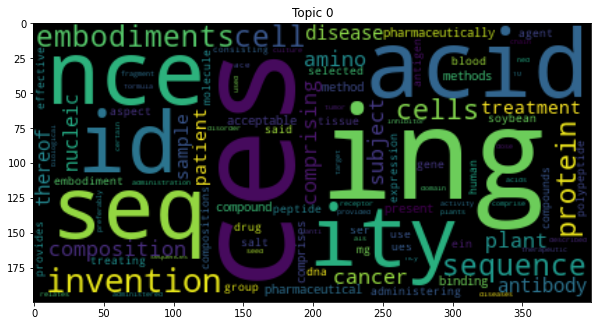

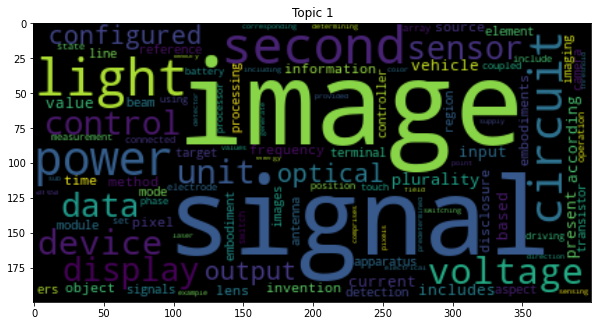

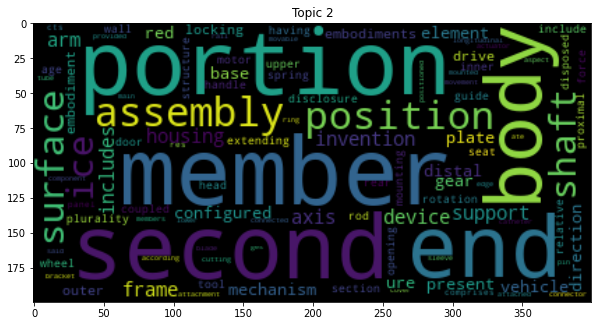

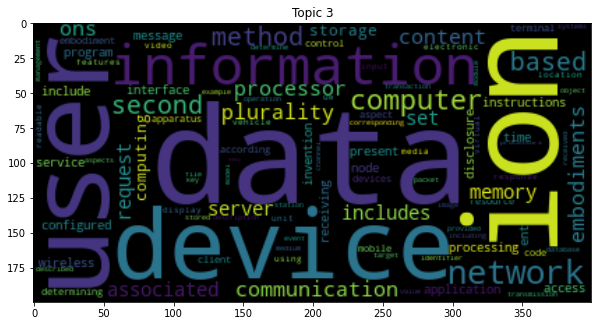

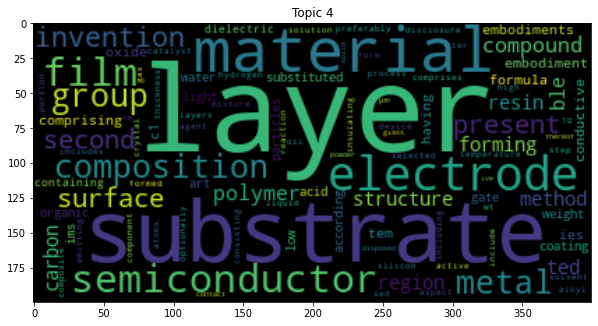

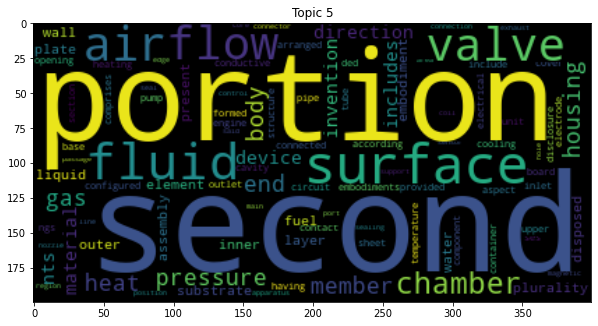

In [ ]:
%%time
from wordcloud import WordCloud

num_max_word_cloud_words = 100

vocab = vectorizer.get_feature_names()
num_topics = len(topic_word_distributions)

for topic_idx in range(num_topics):
    wc = WordCloud(max_words=num_max_word_cloud_words)
    wc.generate_from_frequencies(dict(zip(vocab, topic_word_distributions[topic_idx])))
    plt.figure(figsize=(10, 10))
    plt.imshow(wc, interpolation='bilinear')
    plt.title('Topic %d' % topic_idx)

####From the above topic analysis, each topic seems to be related to the following area:

- topic0: Chemical Substances
- topic1: Image Processing Devices
- topic2: Miscellaneous
- topic3: Computer/Internet Device
- topic4: Material Science
- topic5: Liquid or Flud Ventilation

We notice that rather than AI related technique or method that we at first assumed, there are a lot of device or semiconductor related inventions are still dominant. This is rational result because all these inventions supports the current development of AI technology from the improvement of machine performance such as processing speed or energy efficiency.

### We employ t-sne visualizations to better demonstrate the uniqueness of each topic. 
We test 11 different perplexities in pursuit of these visualizations, and perplexity=30 seems best to show how well our modeling is.

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.013s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000000


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.584267
[t-SNE] KL divergence after 1000 iterations: 0.242885


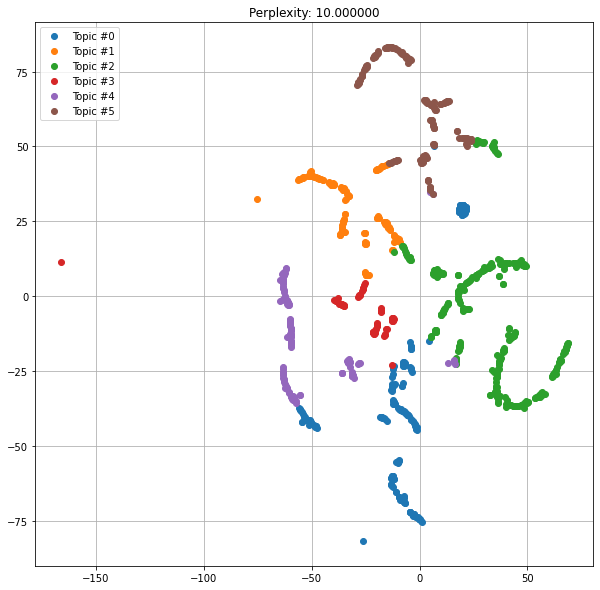

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.020s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000000


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.325512
[t-SNE] KL divergence after 1000 iterations: 0.209586


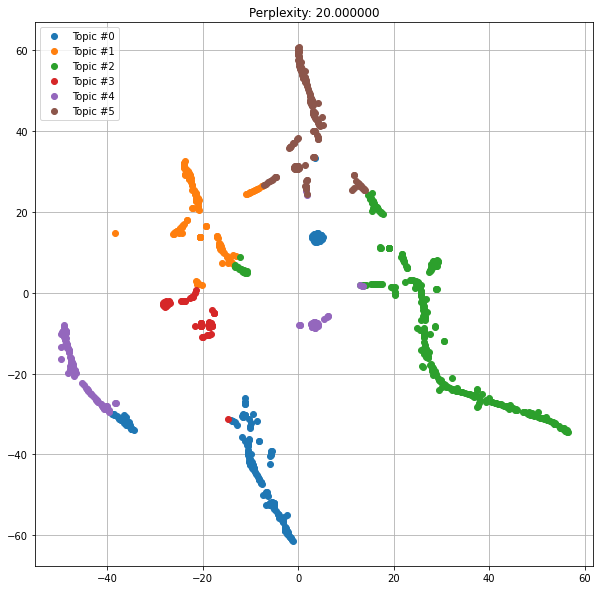

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.029s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.008809


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.727200
[t-SNE] KL divergence after 1000 iterations: 0.192480


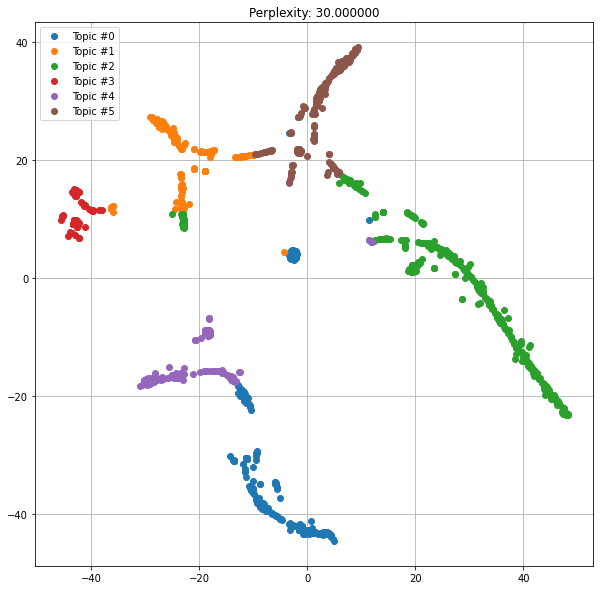

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.041s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.011760


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.226746
[t-SNE] KL divergence after 1000 iterations: 0.193777


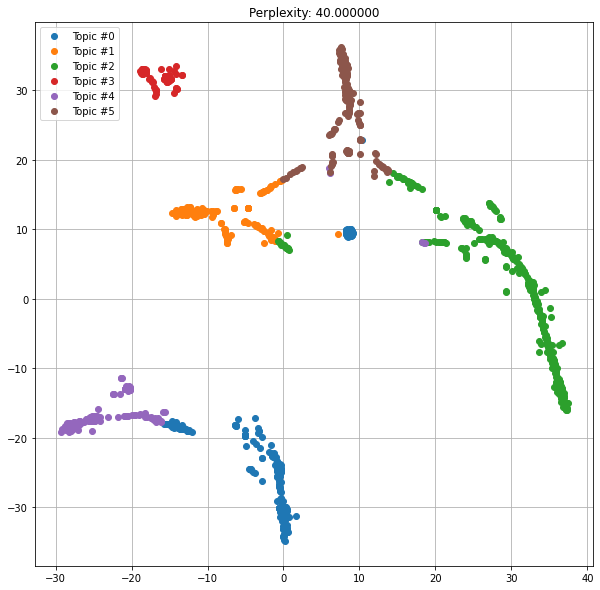

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.044s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.014827


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.130089
[t-SNE] KL divergence after 1000 iterations: 0.192956


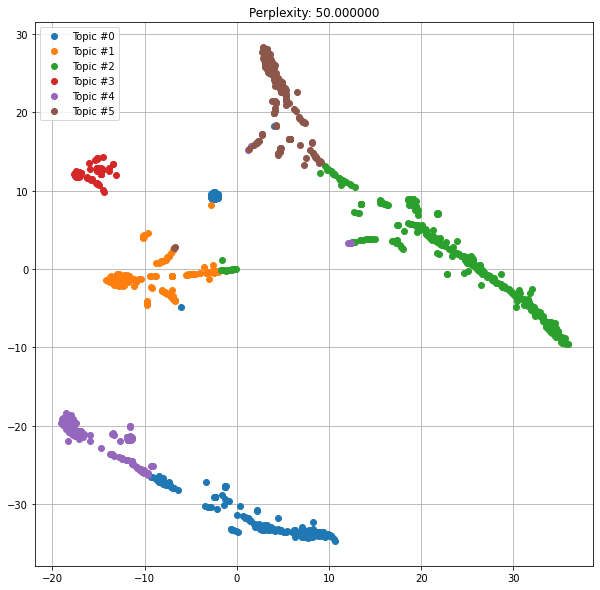

[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.052s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.017963


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.159019
[t-SNE] KL divergence after 1000 iterations: 0.199153


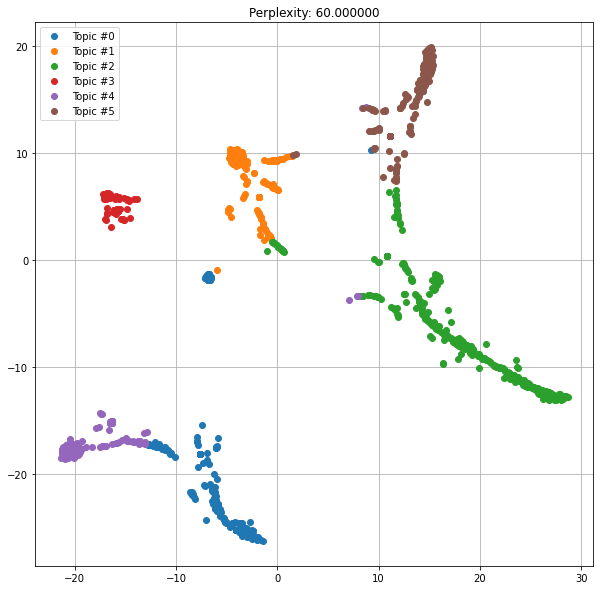

[t-SNE] Computing 211 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.050s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.021157


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.329784
[t-SNE] KL divergence after 800 iterations: 0.195161


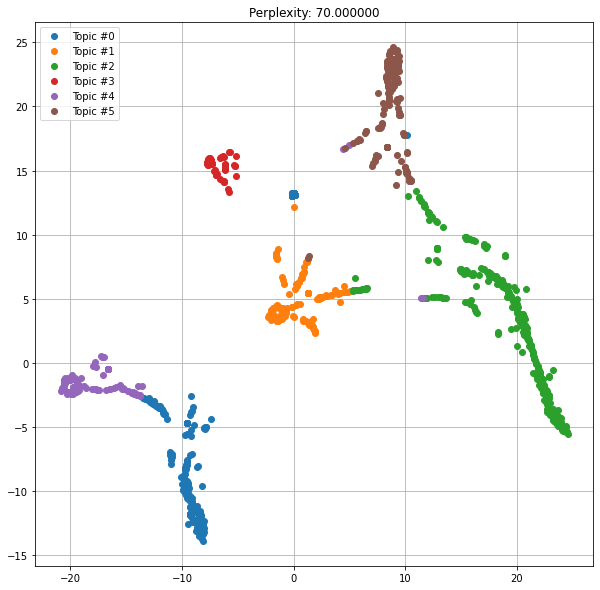

[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.059s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.024495


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.421440
[t-SNE] KL divergence after 1000 iterations: 0.185354


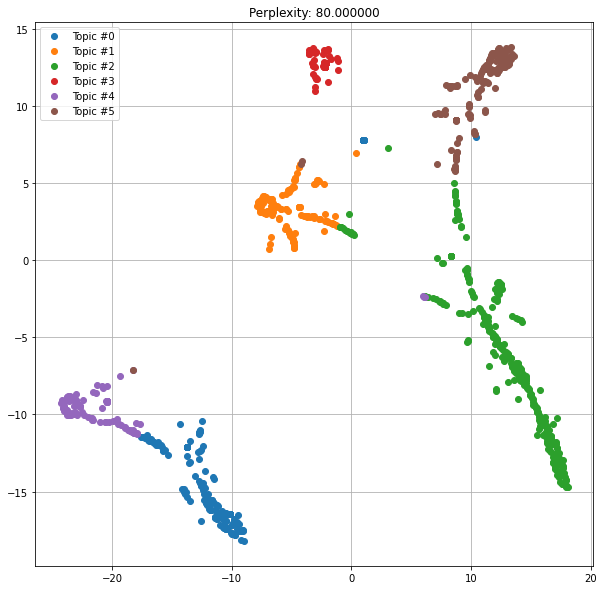

[t-SNE] Computing 271 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.061s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.027999


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.954491
[t-SNE] KL divergence after 1000 iterations: 0.185964


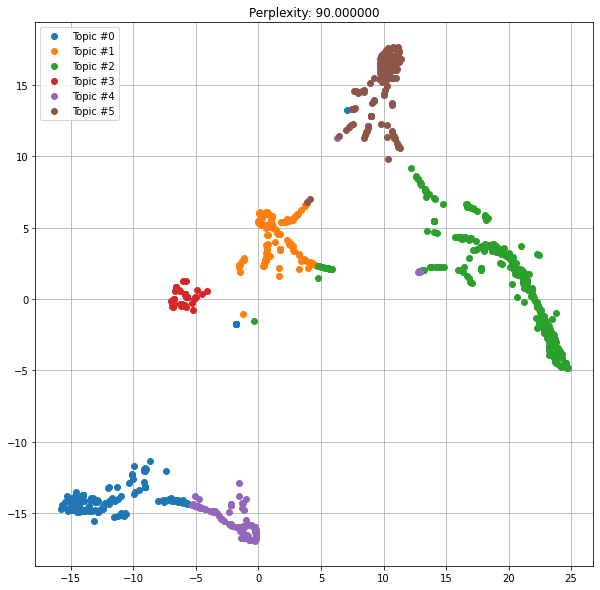

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.064s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.031633


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.940594
[t-SNE] KL divergence after 1000 iterations: 0.188088


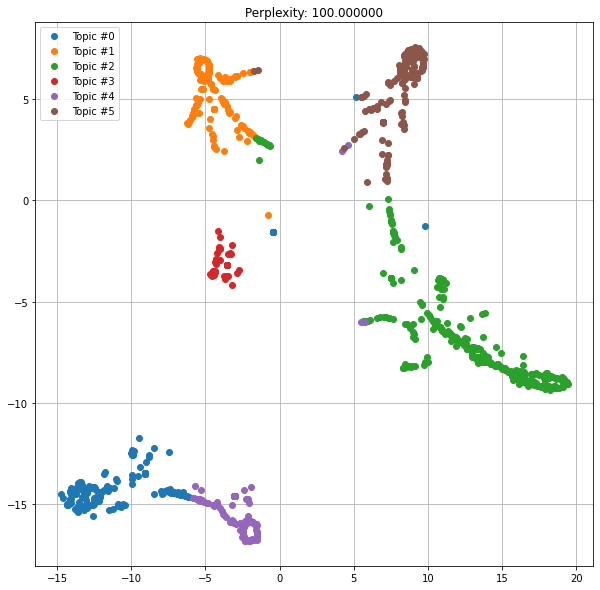

[t-SNE] Computing 999 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.148s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 1125899906842624.000000


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 41.176903
[t-SNE] KL divergence after 1000 iterations: -0.001137


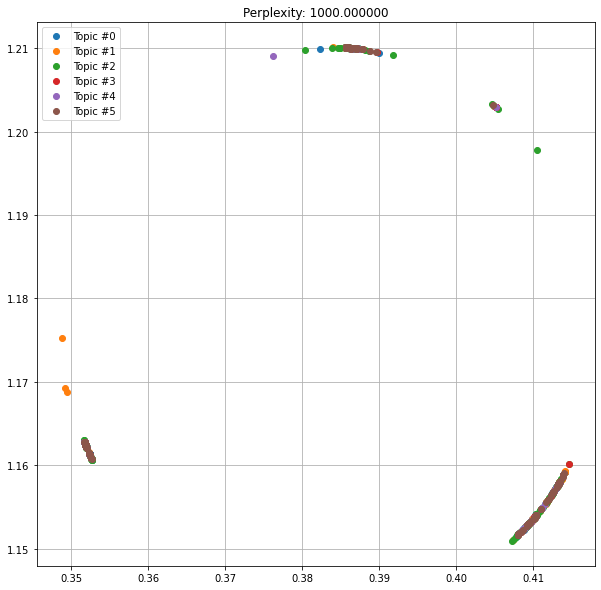

CPU times: user 5min 26s, sys: 44.4 s, total: 6min 11s
Wall time: 2min 11s


In [ ]:
%%time
from sklearn.manifold import TSNE

topic_proportions = lda.transform(X)

for perplexity in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1000]:
    tsne_model = TSNE(n_components=2, learning_rate=800, perplexity=perplexity,
                      verbose=1, random_state=0, angle=.99, init='pca')
    topic_tsne_lda = tsne_model.fit_transform(topic_proportions[:1000,:])

    plt.figure(figsize=(10,10))
    most_probable_topic = np.argmax(topic_proportions, axis=1)[:1000]
    for t in range(num_topics):
        plt.plot(topic_tsne_lda[most_probable_topic==t,0], topic_tsne_lda[most_probable_topic==t,1], 'o',
                 label="Topic #" + str(t))
    plt.legend(loc='upper left')
    plt.title('Perplexity: %f' % perplexity)
    plt.grid()
    plt.show()

Finally, we check the stability of LDA model by running the code 3 times with different random seed (rondom_state=0, 10, and 100) of LDA and comparing the similarity of words in each topic. Then, we can be safe to say that the LDA model with topic 6 is stable. This is because words in each topic are quite similar pattern. The results are as follows:

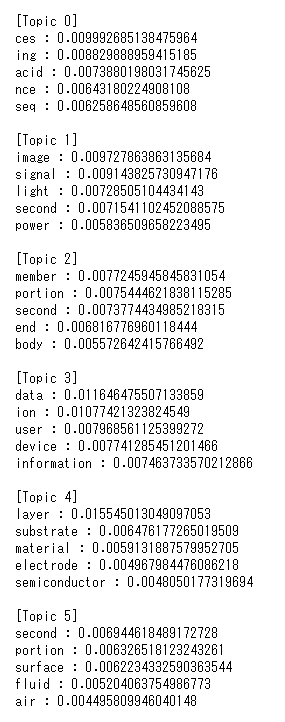

In [ ]:
Image("random_seed_0.png")

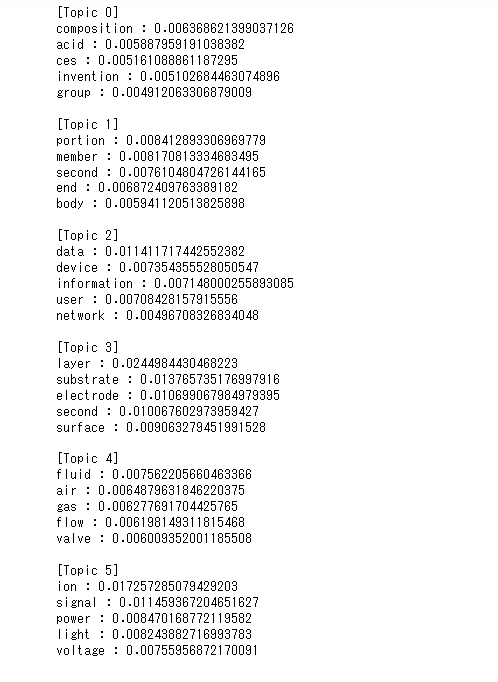

In [ ]:
Image("random_seed_10.png")

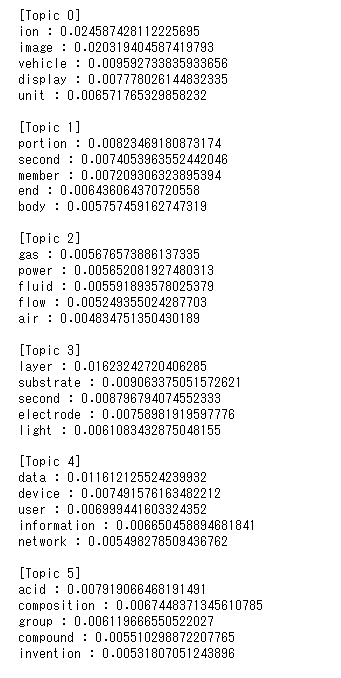

In [ ]:
Image("random_seed_100.png")

##4. Co-Occurrence Analysis (Only 2021 Data)

## Finally we finish confirmation of these Topics by running Co-occurrence Analysis for the Most Recent Patent Data(2021).

In [ ]:
def prob_see_word1_given_see_word2(word1, word2, vectorizer, eps=0.1):
    word1_column_idx = vectorizer.vocabulary_[word1]
    word2_column_idx = vectorizer.vocabulary_[word2]
    documents_with_word1 = (X[:, word1_column_idx].toarray().flatten() > 0)
    documents_with_word2 = (X[:, word2_column_idx].toarray().flatten() > 0)
    documents_with_both_word1_and_word2 = documents_with_word1 * documents_with_word2
    return np.log2((documents_with_both_word1_and_word2.sum() + eps) / documents_with_word2.sum())

In [ ]:
%%time
top_words = list(set(top_word_lis))
co_occ_dic = {}
for i, key_1 in enumerate(top_words):
    for j, key_2 in enumerate(top_words):
        if i < j:
            val = prob_see_word1_given_see_word2(key_1, key_2, vectorizer, eps=0.1)
            key_set = (key_1, key_2)
            co_occ_dic[key_set] = val

CPU times: user 3min 44s, sys: 221 ms, total: 3min 44s
Wall time: 3min 43s


In [ ]:
# Sort the co-occurrence PMI value using the top 5 words in each topic
dict(sorted(co_occ_dic.items(), key=lambda item: -item[1]))

{('acid', 'air'): -3.9685135670520277,
 ('acid', 'body'): -3.845511897179731,
 ('acid', 'ces'): -8.088294605494127,
 ('acid', 'data'): -5.724291785110551,
 ('acid', 'device'): -5.359715411638367,
 ('acid', 'electrode'): -4.08455032420229,
 ('acid', 'end'): -4.437611101186566,
 ('acid', 'fluid'): -3.2007075703168004,
 ('acid', 'image'): -5.979294238422053,
 ('acid', 'information'): -5.475373043404274,
 ('acid', 'ing'): -7.676592976186725,
 ('acid', 'ion'): -2.401328365976563,
 ('acid', 'layer'): -3.7566077894466936,
 ('acid', 'light'): -3.396575625275946,
 ('acid', 'material'): -3.197421432089906,
 ('acid', 'nce'): -8.699448515738043,
 ('acid', 'portion'): -4.313160526182155,
 ('acid', 'power'): -5.615177236375163,
 ('acid', 'second'): -4.3491219504715835,
 ('acid', 'semiconductor'): -4.78046048066725,
 ('acid', 'seq'): -0.17380856783815846,
 ('acid', 'signal'): -4.66798041642468,
 ('acid', 'substrate'): -3.3201833211833423,
 ('acid', 'surface'): -3.844212800056434,
 ('air', 'fluid'): -